In [71]:
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import torch.backends.cudnn as cudnn
from model import TeacherNet, StudentNet
import matplotlib.cm
from matplotlib.cm import ScalarMappable
import os

In [72]:
def enlarge_image(img, scaling = 3):
    if scaling < 1 or not isinstance(scaling,int):
        print ('scaling factor needs to be an int >= 1')

    if len(img.shape) == 2:
        H,W = img.shape
        out = np.zeros((scaling*H, scaling*W))
        for h in range(H):
            fh = scaling*h
            for w in range(W):
                fw = scaling*w
                out[fh:fh+scaling, fw:fw+scaling] = img[h,w]
    elif len(img.shape) == 3:
        H,W,D = img.shape
        out = np.zeros((scaling*H, scaling*W,D))
        for h in range(H):
            fh = scaling*h
            for w in range(W):
                fw = scaling*w
                out[fh:fh+scaling, fw:fw+scaling,:] = img[h,w,:]
    return out
def hm_to_rgb(R, scaling = 10, cmap = 'bwr', normalize = True):
    cmap = eval('matplotlib.cm.{}'.format(cmap))
    if normalize:
        R = R / np.max(np.abs(R)) # normalize to [-1,1] wrt to max relevance magnitude
        R = (R + 1.)/2. # shift/normalize to [0,1] for color mapping
    R = R
    R = enlarge_image(R, scaling)
    rgb = cmap(R.flatten())[...,0:3].reshape([R.shape[0],R.shape[1],3])
    return rgb

def visualize(relevances,name):
    # visualize the relevance
    n = len(relevances)
    heatmap = relevances.reshape([n, 28, 28, 1])
    heatmaps = []
    for h, heat in enumerate(heatmap):
        maps = hm_to_rgb(heat, scaling=10, cmap = 'seismic')
        heatmaps.append(maps)
        im = Image.fromarray((maps*255).astype(np.uint8))
        im.save(name+'.png')
    
def visualize_inp(inp,name):
    heatmap = inp.reshape([28, 28])
    #print(np.min(heatmap))
    
    heatmap = heatmap/ np.max(np.abs(heatmap))
    heatmap = (heatmap + 1)/2
    heatmap = enlarge_image(heatmap, 10)
    
    im = Image.fromarray((heatmap*255).astype(np.uint8))
    im.save(name+'.png')

def compute_pred(output):
    pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
    print('Pred cls : '+str(pred))
    T = pred.squeeze().cpu().numpy()
    T = np.expand_dims(T, 0)
    T = (T[:, np.newaxis] == np.arange(10)) * 1.0
    T = torch.from_numpy(T).type(torch.FloatTensor)
    T.requires_grad = True
    Tt = T.cuda()
    #print(Tt)
    return Tt

In [73]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'    # set visible devices depending on system configuration
device = torch.device('cuda:0')

In [74]:
transform_test = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])

test_dataset = datasets.MNIST(root='./MNIST_dataset/', train=False, 
                                            download=True, transform=transform_test)


In [80]:
model = StudentNet()
model_file = 'checkpoints_student2/T=1, alpha=0.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.001, lr_decay=0.95, weight_decay=0_final.tar'
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = checkpoint['model_state_dict']
model.load_state_dict(state_dict)
model.eval()
device = torch.device('cuda:0')
model.to(device)

StudentNet(
  (fc1): Linear(in_features=784, out_features=800, bias=True)
  (fc2): Linear(in_features=800, out_features=10, bias=True)
  (relu): ReLU(inplace)
  (d_in): Dropout(p=0)
  (d_hidden): Dropout(p=0)
)

In [81]:
pp = 300
input = test_dataset[pp][0].to(device)
print('Original class ',test_dataset[pp][1])
input.requires_grad = True

output = model(input.reshape(1,1,28,28))
T = compute_pred(output)

#T[0,1] = 1
#T[0,6] = 0
#print(T)
#print(output)

#Res = model.relprop(R = output * T, alpha= 1)#.sum(dim=1, keepdim=True)
#heatmap = Res.detach().cpu().numpy()
#visualize(heatmap.reshape([1, 28, 28, 1]), 'output_lrp')


RAP = model.RAP_relprop(R=T)
Res = (RAP)#.sum(dim=1, keepdim=True)
Res = Res.data.cpu().numpy()
visualize(Res.reshape([1, 28, 28, 1]), 'output_rap')


visualize_inp(input.detach().cpu().numpy(),'input')
print('Done')

Original class  4
Pred cls : tensor([[4]], device='cuda:0')
Done


In [82]:
import matplotlib.pyplot as plt
import innvestigate.utils.visualizations as ivis

def plot_image(grid, dpi=28):
    figsize = (4,4)
    plt.clf()
    plt.figure(figsize=figsize)
    #ax = plt.subplot2grid(shape=[1,1], loc=[1, 0])
    grid = ivis.heatmap(grid)
    print(grid.shape)
    plt.imshow(grid, interpolation='none')
    
    plt.show()

(28, 28, 3)


<Figure size 432x288 with 0 Axes>

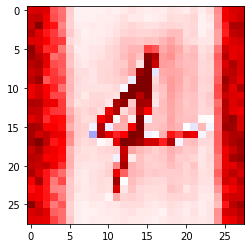

In [83]:
#heatmap = (heatmap-0.5)*2
#print(heatmap[0,0])
plot_image(Res.reshape([28,28,1]))

tensor([2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])
